In [11]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
pd.options.display.float_format = '{:,.4f}'.format
from scipy.stats import norm as norm
from pandas_datareader.data import Options
import py_vollib.black.greeks.analytical as py_greeks
from scipy.stats import norm as norm

# from alpha_vantage.timeseries import TimeSeries
#ts = TimeSeries(key='5HZEUI5AFJB06BUK',output_format='pandas')
#key2 = '6ZAZOL7YF8VPXND7'

init_notebook_mode(connected=True)

import os
main_dir = os.getcwd()

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\RetiredModules')

from helpers import maturities

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')

cleaned_dir = 'D:\\Options Data\\Aggregated DBs'

from alphavantage import *
from yahoo_query import *

spx = yahoo_query('^GSPC',dt.datetime(2018,1,1))
spx.hist_prices_query()
spx = spx.hist_prices

vix = yahoo_query('^VIX',dt.datetime(2018,1,1))
vix.hist_prices_query()
vix = vix.hist_prices

spx.index = pd.to_datetime(spx.index)
vix.index = pd.to_datetime(vix.index)

In [12]:
vol_window = 5
market_close_hour = 13

def expiration_options_price(vol_window, market_close_hour, use_iv = 'prices'):

    spx_ticker = '^GSPC'
    spx_minutely = yahoo_query(spx_ticker, dt.datetime(2018,1,1))
    spx_minutely.minute_query()
    spx_minutely = spx_minutely.minute_prices
    spx_minutely.columns = [col.replace('^', '') for col in spx_minutely.columns.tolist()]
    spx_minutely['returns'] = np.log(spx_minutely.GSPC_close) - np.log(spx_minutely.GSPC_close.shift(1))

    vix_ticker = '^VIX'
    vix_minutely = yahoo_query(vix_ticker, dt.datetime(2018,1,1))
    vix_minutely.minute_query()
    vix_minutely = vix_minutely.minute_prices
    vix_minutely.columns = [col.replace('^', '') for col in vix_minutely.columns.tolist()]

    current_minute_vol = spx_minutely.returns.rolling(vol_window).std().tail(1).values[0]
    latest_vix = vix_minutely.dropna().tail(1).VIX_close.values[0]
    latest_stdev = latest_vix/(100*np.sqrt(252))

    latest_spx = spx_minutely.dropna().tail(1).GSPC_close.values[0]
    latest_range = [latest_spx*(1 - 2*latest_stdev), latest_spx*(1 + 2*latest_stdev)]
    strike_range = list(range(int(np.floor(latest_range[0]/10)*10), int(np.ceil(latest_range[1]/10)*10) + 5,5))

    current_time = dt.datetime.now()
    market_close = dt.datetime(current_time.year, current_time.month, current_time.day, market_close_hour, 0)

    minutes_to_close = (market_close - current_time).seconds/60

    raw_chain = pd.DataFrame({'Strike': strike_range})
    raw_chain['Underlying_Price'] = latest_spx
    
    if type(use_iv) == str:
        raw_chain['IV'] = current_minute_vol
    else:
        raw_chain['IV'] = use_iv
    raw_chain['MTE'] = minutes_to_close

    options_df = raw_chain.copy()
    options_df['sigma_sqrt_T'] = np.sqrt(options_df.MTE)*options_df.IV
    options_df['d1'] = (np.log(options_df.Underlying_Price/options_df.Strike) + ((options_df.IV**2)/2)*options_df.MTE)/(options_df.IV*np.sqrt(options_df.MTE))
    options_df['d2'] = options_df.d1 - options_df.sigma_sqrt_T
    options_df['Nd1'] = norm.cdf(options_df.d1)
    options_df['Nd2_PV'] = norm.cdf(options_df.d2)*options_df.Strike

    options_df['Call_Price'] = np.round(options_df.Nd1*options_df.Underlying_Price - options_df.Nd2_PV, 2)

    options_df['Put_Price'] = np.round(options_df.Call_Price + options_df.Strike - options_df.Underlying_Price, 2)

    options_df = options_df[['Strike','Underlying_Price','IV','MTE','Call_Price','Put_Price']].set_index('Strike')
    return options_df, spx_minutely, vix_minutely

def delta_0dte(options_df):
    d1 = (np.log(options_df['Underlying_Price'] / 
                 options_df['Strike']) + 
          (options_df['IV']**2 / 2.0) * np.sqrt(options_df['TimeRemaining'])) / (options_df['IV'] * np.sqrt(options_df['TimeRemaining']))
    if options_df.Type[0] == 'call':
        return norm.cdf(d1)
    elif options_df.Type[0] == 'put':
        return 1 - norm.cdf(d1)
    
def gamma_0dte(options_df):
    d1 = (np.log(options_df['Underlying_Price'] / 
                 options_df['Strike']) + 
          (options_df['IV']**2 / 2.0) * np.sqrt(options_df['TimeRemaining'])) / (options_df['IV'] * np.sqrt(options_df['TimeRemaining']))

    return norm.pdf(d1)/(options_df['Underlying_Price']*options_df['IV']*np.sqrt(options_df['TimeRemaining']))


def make_plot_surface(options_df, std = 2, surface_display = 'IV'):

    plot_df = options_df[options_df.Quote_Time.dt.time <= dt.time(16,0)].reset_index(drop = True)
    
    spx_open = spx[spx.index.date == plot_df.loc[0,'Quote_Time'].date()]['^GSPC_open'].values[0]
    vix_open = vix[vix.index.date == plot_df.loc[0,'Quote_Time'].date()]['^VIX_open'].values[0]
    std_dollars = spx_open*vix_open/(np.sqrt(252)*100)

    plot_df = plot_df[(plot_df.Strike >= spx_open - std*std_dollars) &
                      (plot_df.Strike <= spx_open + std*std_dollars)]

    plot_df.TimeRemaining = plot_df.TimeRemaining*60*24*365.25

    strikeGrid, dteGrid = np.meshgrid(plot_df['Strike'].drop_duplicates(), plot_df['TimeRemaining'].drop_duplicates())
    zGrid = plot_df[surface_display].values.reshape(strikeGrid.shape)

    surface1 = go.Surface(x = strikeGrid, 
                          y = dteGrid, 
                          z = zGrid,
                          name = '{} Surface'.format(surface_display))

    layout = go.Layout(
                title='{0} {1} Surface'.format(options_df.loc[0,'Type'],surface_display),
                autosize=True,
                showlegend = False,
                scene=dict(
                    aspectmode = 'manual',
                    aspectratio = dict(x = 2,
                                       y = 2,
                                       z = 1),
                    camera = dict(up = dict(x = 0,
                                            y = 0,
                                            z = 1),
                                  center = dict(x = 0,
                                                y = 0,
                                                z = 0),
                                  eye = dict(x = 1,
                                             y = 1,
                                             z = 0.5)),
                    xaxis=dict(
                        title='Strike',
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    ),
                    yaxis=dict(
                        title='Time Remaining',
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    ),
                    zaxis=dict(
                        title = surface_display,
                        gridcolor='rgb(255, 255, 255)',
                        zerolinecolor='rgb(255, 255, 255)',
                        showbackground=True,
                        backgroundcolor='rgb(230, 230,230)'
                    )
                )
            )

    data = [surface1]
    figure = dict(data=data, layout=layout)
    return figure

In [3]:
vol_window = 60
market_close_hour = 13
use_iv = 0.0005
minutes = 97740
options_df, spx_minutely, vix_minutely = expiration_options_price(vol_window, market_close_hour, use_iv)

downs = spx_minutely[spx_minutely.returns < 0][['returns']]
ups = spx_minutely[spx_minutely.returns > 0][['returns']]

spx_bands = spx_minutely[['GSPC_close']].join(vix_minutely[['VIX_close']]).dropna()


current_time = spx_bands.index[-1] - dt.timedelta(seconds = 60*60*4)
market_close = dt.datetime(current_time.year, current_time.month, current_time.day, market_close_hour, 0)

minutes_to_close = (market_close - current_time).seconds/60
days_to_close = minutes_to_close/390

# spx_bands['UB'] = (1 + spx_bands['VIX_close']/(100*np.sqrt(252/days_to_close)))*spx_bands.GSPC_close
# spx_bands['LB'] = (1 - spx_bands['VIX_close']/(100*np.sqrt(252/days_to_close)))*spx_bands.GSPC_close

# spx_bands

# Analysis of Minutely Time Series and Options at Expiration

In [4]:
v1 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX1.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
v2 = pd.read_csv('https://www.quandl.com/api/v3/datasets/CHRIS/CBOE_VX2.csv?api_key=dzmzEExntfap7SNx5p6t', index_col = 0)[['Open','Close']].sort_index()
vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', skiprows=[0], index_col = 0)
vix.index = pd.to_datetime(vix.index)
v_df = vix.join(v1.join(v2, lsuffix = '_F1', rsuffix = '_F2').dropna()).dropna()
v_df['Front_Weights'] = np.nan
v_df['Back_Weights'] = np.nan

for index, row in v_df.iterrows():
    weights = maturities(index.date())
    front_weight = weights[0]
    back_weight = weights[1]
    v_df.loc[index, 'Front_Weights'] = front_weight
    v_df.loc[index, 'Back_Weights'] = back_weight

In [5]:
vix_term = v_df[list(filter(lambda x: 'Open' in x or 'Weight' in x, v_df.columns.tolist()))]
vix_term['Contango_Ratio'] = vix_term.Front_Weights*(vix_term['VIX Open']/vix_term.Open_F1) + vix_term.Back_Weights*(vix_term.Open_F1/vix_term.Open_F2)
vix_term = vix_term[vix_term.index >= dt.datetime(2018,7,30)]

In [45]:
os.chdir(cleaned_dir)

lookup_date = dt.date(2018,10,1)
options_db = 'sqlite:///options_{0}-{1}.db'.format(lookup_date.year,lookup_date.month)
options_engine = create_engine(options_db, echo = False)

index_db = 'sqlite:///indices_intraday_{0}-{1}.db'.format(lookup_date.year,lookup_date.month)
index_engine = create_engine(index_db, echo = False)

dte_filter = 0

table = options_engine.table_names()[1]

index_query = 'SELECT * FROM "{}"'.format(table)
try:
    index_table = pd.read_sql_query(index_query, con = index_engine, index_col = 'index')
except:
    index_table = pd.read_sql_query(index_query, con = index_engine, index_col = 'Quote_Time')

index_table.index = pd.to_datetime(index_table.index)

    
query_calls = 'SELECT * FROM "{0}" WHERE type = "call" AND dte = "{1}"'.format(table,dte_filter)
query_puts = 'SELECT * FROM "{0}" WHERE type = "put" AND dte = "{1}"'.format(table,dte_filter)

calls = pd.read_sql_query(query_calls, con = options_engine, index_col = 'index')
calls.Expiry = pd.to_datetime(calls.Expiry)
calls.Quote_Time = pd.to_datetime(calls.Quote_Time)
calls = calls.sort_values(['Quote_Time','Strike']).reset_index(drop = True)

puts = pd.read_sql_query(query_puts, con = options_engine, index_col = 'index')
puts.Expiry = pd.to_datetime(puts.Expiry)
puts.Quote_Time = pd.to_datetime(puts.Quote_Time)
puts = puts.sort_values(['Quote_Time','Strike']).reset_index(drop = True)

print(table)

calls.sort_values('Quote_Time')

day_2018-10-15


,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Vol,Open_Int,IV,Root,Underlying_Price,Quote_Time,DTE,TradeDate,VIX,TimeRemaining,Delta,Gamma
0,"1,900.0000",2018-10-15 16:00:01,call,SPXW181015C01900000,"1,003.9800",854.1000,867.0000,12.0000,5.0000,3.5049,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,1.0000,0.0000
64,"2,970.0000",2018-10-15 16:00:01,call,SPXW181015C02970000,0.0500,0.0000,0.0500,514.0000,804.0000,0.4863,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
63,"2,965.0000",2018-10-15 16:00:01,call,SPXW181015C02965000,0.0800,0.0000,0.0500,4.0000,604.0000,0.4746,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
62,"2,960.0000",2018-10-15 16:00:01,call,SPXW181015C02960000,0.0500,0.0000,0.0500,45.0000,679.0000,0.4648,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
61,"2,955.0000",2018-10-15 16:00:01,call,SPXW181015C02955000,0.0300,0.0000,0.0500,10.0000,"1,594.0000",0.4551,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
60,"2,950.0000",2018-10-15 16:00:01,call,SPXW181015C02950000,0.0800,0.0000,0.0500,40.0000,"1,478.0000",0.4443,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
59,"2,945.0000",2018-10-15 16:00:01,call,SPXW181015C02945000,0.0500,0.0000,0.0500,10.0000,"1,432.0000",0.4336,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
58,"2,940.0000",2018-10-15 16:00:01,call,SPXW181015C02940000,0.0900,0.0000,0.0500,8.0000,"3,151.0000",0.4238,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
57,"2,935.0000",2018-10-15 16:00:01,call,SPXW181015C02935000,0.0500,0.0000,0.0500,11.0000,813.0000,0.4121,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000
65,"2,975.0000",2018-10-15 16:00:01,call,SPXW181015C02975000,0.0500,0.0000,0.0500,15.0000,"2,123.0000",0.4961,SPXW,"2,763.8300",2018-10-15 09:30:00,0,2018-10-15,21.6000,0.0007,0.0000,0.0000


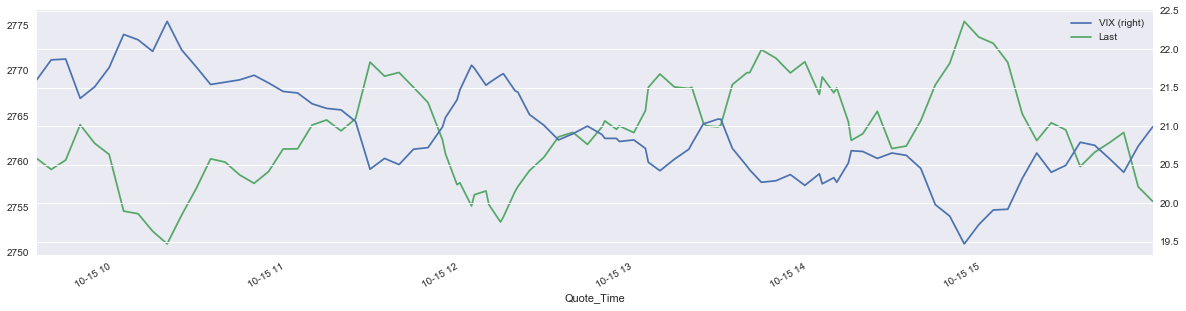

In [46]:
df = puts
df['Mid'] = (df['Ask'] - df['Bid'])/2
std = 4
fig_gamma = make_plot_surface(df, std, surface_display = 'Gamma')
fig_delta = make_plot_surface(df, std, surface_display = 'Delta')
fig_iv = make_plot_surface(df, std, surface_display = 'IV')
fig_mid = make_plot_surface(df, std, surface_display = 'Mid')


index_table.plot(figsize = (20,5), secondary_y = 'VIX')

In [47]:
iplot(fig_delta)

In [48]:
iplot(fig_gamma)

In [49]:
iplot(fig_iv)

In [ ]:


# pd.merge_asof(left=latest_calls[(latest_calls.index < dt.datetime(2019,1,3)) &
#                                 (latest_calls.Strike >= 2490) &
#                                 (latest_calls.Strike <= 2520)].sort_index(),
#               right=index_intraday[['VIX']],
#               right_index=True,
#               left_index=True,
#               direction='nearest',
#               tolerance=tol).dropna(subset = ['VIX'])[['Strike','IV',
#                                                        'Underlying_Price',
#                                                        'VIX']].reset_index().set_index(['quoteTime',
#                                                                                         'Strike'])

# option_underlying = latest_calls[['Underlying_Price']][~latest_calls.index.duplicated(keep='first')].sort_index()

# latest_spx.index.date

# test_opening = spx_intraday.drop_duplicates('Date', keep='first')
# test_closing = spx_intraday.drop_duplicates('Date', keep='last')


# test_opening[test_opening.index.minute != 30]



# test_closing[(test_closing.index.hour != 16) | 
#              (test_closing.index.minute != 0)]



# minutes = spx_intraday.groupby('Date').count()
# minutes = minutes.reset_index()
# minutes.groupby('Last').count()
# minutes[minutes['Last'] != 391]


# test_day = spx_intraday[spx_intraday.Date == dt.date(2018,8,9)]
# test_day['timediff'] = test_day.index.to_series().diff().dt.seconds
# test_day[test_day.timediff != 60]